---
---
*<h1 align='center'> Causal Sentence Detection </h1>*
*<h2 align='center'> Model: Bi-GRU-Att </h2>*
---
---
Name: Logesh.V <br>
Email: vlogesh2001@gmail.com <br>
DATASETS: 
- Causaly_small: https://archive.org/details/CausalySmall <br>
About Dataset: The dataset contains 2000 manually annotated sentences derived from
pubmed articles. 1113 out of 2000 sentences are annotated as Causal (Annotated_Causal = 1) and the rest (887) are annotated as non-Causal (Annotated_Causal = 0).

In [1]:
# import required packages

import pandas as pd
import re
from tensorflow import argmax, string
from tensorflow.keras.layers import Layer, Embedding, Bidirectional, Attention, GRU, Dense, SpatialDropout1D, LSTM
from tensorflow.keras import layers, Model

from tensorflow.keras import backend as K, Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Causaly_small.csv")
data.columns

Index(['Sentence', 'Annotated_Causal'], dtype='object')

In [3]:
print(len(data))
data.head()

2000


,Sentence,Annotated_Causal
0,"Results indicated that boys with ADHD , relati...",1
1,Ticagrelor appears to provide higher value for...,0
2,"Whatever the mechanism , active smoking is an ...",1
3,"In this study , we examined whether use of an ...",0
4,"Using causal inference testing , we searched c...",0


In [4]:
max_features = 4000

In [5]:
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['Sentence'].values)

In [6]:
X = tokenizer.texts_to_sequences(data['Sentence'].values)

In [7]:
X = pad_sequences(X)

In [8]:
X.shape

(2000, 92)

In [9]:
Y = pd.get_dummies(data['Annotated_Causal'])

In [10]:
result_dict = {0: 'False', 1: 'True'}
y_arr = np.vectorize(result_dict.get)(Y.columns)

In [11]:
Y = Y.values

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

In [13]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1340, 92) (1340, 2)
(660, 92) (660, 2)


In [14]:
from tensorflow.keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [19]:
embed_dim = 256
gru_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(GRU(gru_out, dropout=0.05, recurrent_dropout=0.2, return_sequences=True)))
model.add(Attention(return_sequences=False)) # receive 3D and output 2D
model.add(Dense(2, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 92, 256)           1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 92, 256)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 92, 392)          533904    
 l)                                                              
                                                                 
 attention (Attention)       (None, 392)               484       
                                                                 
 dense (Dense)               (None, 2)                 786       
                                                                 
Total params: 1,559,174
Trainable params: 1,559,174
Non-

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [21]:
es = EarlyStopping(monitor='accuracy', patience=5)

history = model.fit(X_train, Y_train, epochs=20, batch_size=128, verbose=2, callbacks=[es])

Epoch 1/20
11/11 - 31s - loss: 0.6918 - accuracy: 0.5515 - 31s/epoch - 3s/step
Epoch 2/20
11/11 - 29s - loss: 0.6868 - accuracy: 0.5724 - 29s/epoch - 3s/step
Epoch 3/20
11/11 - 46s - loss: 0.6761 - accuracy: 0.5634 - 46s/epoch - 4s/step
Epoch 4/20
11/11 - 25s - loss: 0.5773 - accuracy: 0.7590 - 25s/epoch - 2s/step
Epoch 5/20
11/11 - 26s - loss: 0.3682 - accuracy: 0.8351 - 26s/epoch - 2s/step
Epoch 6/20
11/11 - 43s - loss: 0.2228 - accuracy: 0.9239 - 43s/epoch - 4s/step
Epoch 7/20
11/11 - 68s - loss: 0.1371 - accuracy: 0.9672 - 68s/epoch - 6s/step
Epoch 8/20
11/11 - 43s - loss: 0.0664 - accuracy: 0.9784 - 43s/epoch - 4s/step
Epoch 9/20
11/11 - 37s - loss: 0.0393 - accuracy: 0.9903 - 37s/epoch - 3s/step
Epoch 10/20
11/11 - 23s - loss: 0.0430 - accuracy: 0.9933 - 23s/epoch - 2s/step
Epoch 11/20
11/11 - 27s - loss: 0.0125 - accuracy: 0.9985 - 27s/epoch - 2s/step
Epoch 12/20
11/11 - 24s - loss: 0.0063 - accuracy: 0.9978 - 24s/epoch - 2s/step
Epoch 13/20
11/11 - 23s - loss: 0.0045 - accuracy

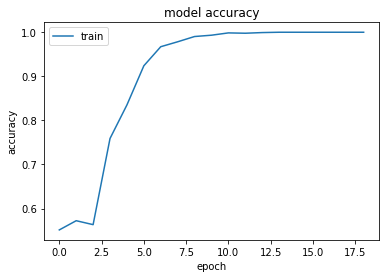

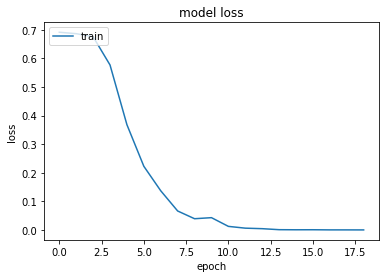

In [22]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [23]:
score, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=64)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

11/11 - 5s - loss: 2.3815 - accuracy: 0.7364 - 5s/epoch - 432ms/step
score: 2.38
acc: 0.74


In [24]:
print("Predicting Test data using the above Trained model...")
pred = model.predict(X_test)

Predicting Test data using the above Trained model...


In [25]:
class_names = ['Not Causal','Causal']

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [27]:
test = argmax(Y_test, axis = 1)
pred = np.argmax(pred, axis=1) # to get the indices of max value in each row
print(classification_report(test, pred, target_names=class_names))

              precision    recall  f1-score   support

  Not Causal       0.71      0.67      0.69       291
      Causal       0.75      0.79      0.77       369

    accuracy                           0.74       660
   macro avg       0.73      0.73      0.73       660
weighted avg       0.74      0.74      0.74       660



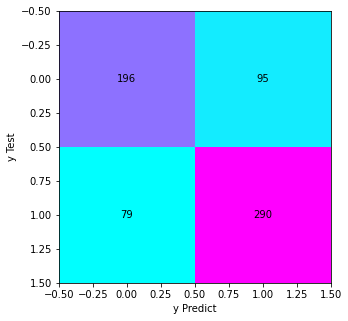

In [28]:
CM = confusion_matrix(test, pred)
# Plot confusion matrix
plt.figure(figsize = (5,5))
plt.imshow(CM,interpolation='nearest',cmap='cool')
for (i, j), z in np.ndenumerate(CM):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y Test")
plt.grid(False)
plt.show()

---
#### *<div style="text-align: center"> - - - - - Thank You - - - - - <div>*
---